In [ ]:
# Load data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
# Load machine learning libraries
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [3]:
# If true, only the 3% of the data will be used for training and testing of the various models
_DEVMODE = True

In [4]:
# Loading the data from the train and test files
train_df = pd.read_csv(r'C:\Users\pooja\Downloads\network-attack-detection-main\network-attack-detection-main\train_net.csv')
test_df = pd.read_csv(r'C:\Users\pooja\Downloads\network-attack-detection-main\network-attack-detection-main\test_net.csv')

In [5]:
# Print total size
print("Test set size: ", test_df.shape)
print("Train set size: ", train_df.shape)

# Value counts
train_df['ALERT'].value_counts()

Test set size:  (2077339, 32)
Train set size:  (4217625, 33)


ALERT
Port Scanning        507845
Denial of Service     50392
Malware                 388
Name: count, dtype: int64

In [6]:
if _DEVMODE:
    train_df = train_df.sample(frac=0.03, random_state=1)
    test_df = test_df.sample(frac=0.03, random_state=1)

    # Print total size
    print("Test set size: ", test_df.shape)
    print("Train set size: ", train_df.shape)


Test set size:  (62320, 32)
Train set size:  (126529, 33)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126529 entries, 1283232 to 959711
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FLOW_ID                     126529 non-null  int64  
 1   PROTOCOL_MAP                126529 non-null  object 
 2   L4_SRC_PORT                 126529 non-null  int64  
 3   IPV4_SRC_ADDR               126529 non-null  object 
 4   L4_DST_PORT                 126529 non-null  int64  
 5   IPV4_DST_ADDR               126529 non-null  object 
 6   FIRST_SWITCHED              126529 non-null  int64  
 7   FLOW_DURATION_MILLISECONDS  126529 non-null  int64  
 8   LAST_SWITCHED               126529 non-null  int64  
 9   PROTOCOL                    126529 non-null  int64  
 10  TCP_FLAGS                   126529 non-null  int64  
 11  TCP_WIN_MAX_IN              126529 non-null  int64  
 12  TCP_WIN_MAX_OUT             126529 non-null  int64  
 13  TCP_WIN_MIN_I

In [9]:
# Show information about the data
def printInfo(df):
    print('Dataframe shape: ', df.shape)
    print('Dataframe columns: ', df.columns)

print('==== Train data ====')
printInfo(train_df)
print()
print('==== Test data ====')
printInfo(test_df)

==== Train data ====
Dataframe shape:  (126529, 33)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN',
       'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN', 'TCP_WIN_SCALE_IN',
       'TCP_WIN_SCALE_OUT', 'SRC_TOS', 'DST_TOS', 'TOTAL_FLOWS_EXP',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TOTAL_PKTS_EXP', 'TOTAL_BYTES_EXP',
       'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'ANALYSIS_TIMESTAMP',
       'ANOMALY', 'ALERT', 'ID'],
      dtype='object')

==== Test data ====
Dataframe shape:  (62320, 32)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', '

In [10]:
train_df.head()

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
1283232,372246818,tcp,62980,10.114.241.166,47736,10.114.224.117,1647766047,0,1647766047,6,...,0,0,44,1,40,1,1647766568,0.0,Port Scanning,1283232
3327778,372024895,udp,44246,10.114.227.143,53,10.114.226.5,1647761040,0,1647761040,17,...,0,0,73,1,121,1,1647761116,0.0,NaN,3327778
3341312,334833539,tcp,36150,10.114.225.212,5228,74.125.133.188,1647346083,144,1647346083,6,...,0,0,132,2,130,2,1647346141,NaN,NaN,3341312
1704357,369619889,tcp,33858,10.114.225.206,6443,10.114.232.94,1647693586,0,1647693586,6,...,0,0,60,1,0,0,1647693660,1.0,NaN,1704357
4163521,371759146,udp,48586,10.114.227.52,53,10.114.226.5,1647752706,0,1647752706,17,...,0,0,91,1,146,1,1647752852,0.0,NaN,4163521


In [45]:
# Check for missing values
print('==== Train data ====')
print(train_df.isnull().sum())
print()
print('==== Test data ====')
print(test_df.isnull().sum())
print()

==== Train data ====
FLOW_ID                            0
PROTOCOL_MAP                       0
L4_SRC_PORT                        0
IPV4_SRC_ADDR                      0
L4_DST_PORT                        0
IPV4_DST_ADDR                      0
FIRST_SWITCHED                     0
FLOW_DURATION_MILLISECONDS         0
LAST_SWITCHED                      0
PROTOCOL                           0
TCP_FLAGS                          0
TCP_WIN_MAX_IN                     0
TCP_WIN_MAX_OUT                    0
TCP_WIN_MIN_IN                     0
TCP_WIN_MIN_OUT                    0
TCP_WIN_MSS_IN                     0
TCP_WIN_SCALE_IN                   0
TCP_WIN_SCALE_OUT                  0
SRC_TOS                            0
DST_TOS                            0
TOTAL_FLOWS_EXP                    0
MIN_IP_PKT_LEN                     0
MAX_IP_PKT_LEN                     0
TOTAL_PKTS_EXP                     0
TOTAL_BYTES_EXP                    0
IN_BYTES                           0
IN_PKTS          

In [11]:
# Fill the missing ANOMALY values with 0 (no anomaly)
train_df['ANOMALY'].fillna(0, inplace=True)
test_df['ANOMALY'].fillna(0, inplace=True)

In [12]:
train_df.dtypes

FLOW_ID                         int64
PROTOCOL_MAP                   object
L4_SRC_PORT                     int64
IPV4_SRC_ADDR                  object
L4_DST_PORT                     int64
IPV4_DST_ADDR                  object
FIRST_SWITCHED                  int64
FLOW_DURATION_MILLISECONDS      int64
LAST_SWITCHED                   int64
PROTOCOL                        int64
TCP_FLAGS                       int64
TCP_WIN_MAX_IN                  int64
TCP_WIN_MAX_OUT                 int64
TCP_WIN_MIN_IN                  int64
TCP_WIN_MIN_OUT                 int64
TCP_WIN_MSS_IN                  int64
TCP_WIN_SCALE_IN                int64
TCP_WIN_SCALE_OUT               int64
SRC_TOS                         int64
DST_TOS                         int64
TOTAL_FLOWS_EXP                 int64
MIN_IP_PKT_LEN                  int64
MAX_IP_PKT_LEN                  int64
TOTAL_PKTS_EXP                  int64
TOTAL_BYTES_EXP                 int64
IN_BYTES                        int64
IN_PKTS     

<Axes: xlabel='ALERT', ylabel='count'>

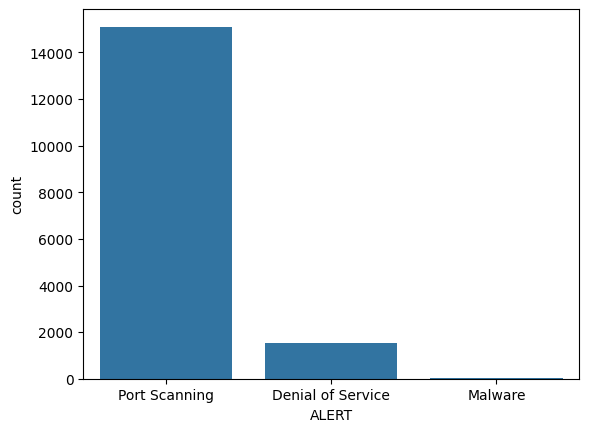

In [13]:
# Show the distribution of the target variable
sns.countplot(x='ALERT', data=train_df)

In [14]:
# Count the number of unique protocol_maps
train_df['PROTOCOL_MAP'].value_counts()

PROTOCOL_MAP
tcp          62514
udp          54250
icmp          9728
gre             36
ipv6-icmp        1
Name: count, dtype: int64

[Text(0.5, 1.0, 'L4_SRC_PORT')]

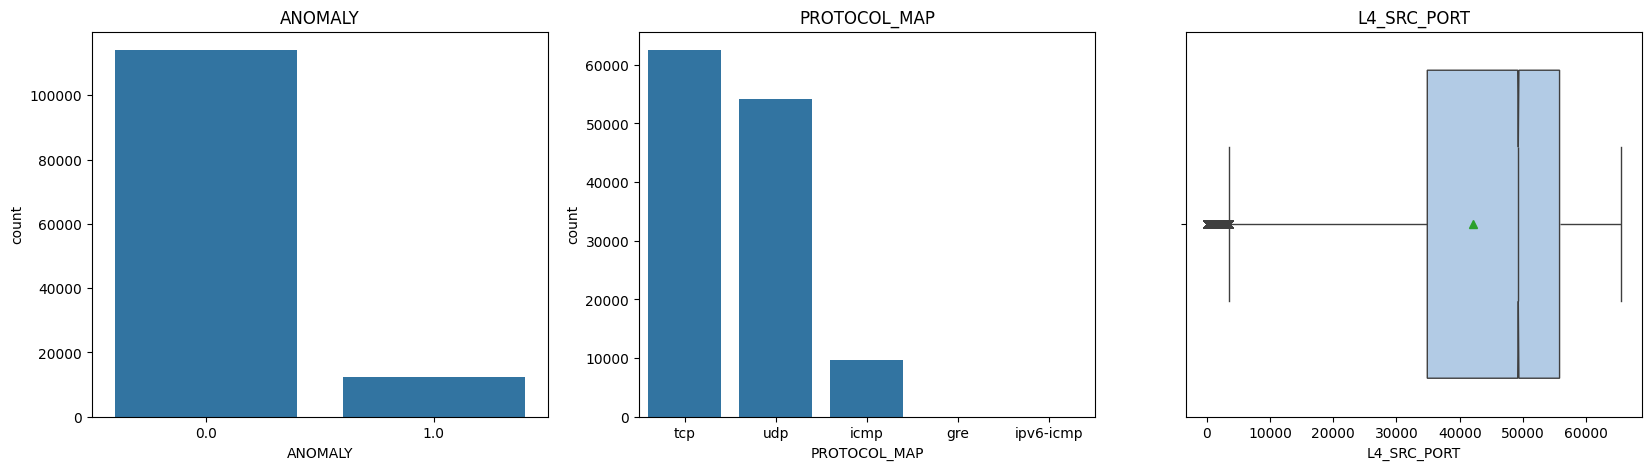

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# seaborn countplots
sns.countplot(x='ANOMALY', data=train_df, ax=axs[0]).set(title='ANOMALY')
              

# Seaborn countplot for the 'PROTOCOL_MAP' column, with enough space for the labels
sns.countplot(x='PROTOCOL_MAP', data=train_df, ax=axs[1]).set(title='PROTOCOL_MAP')

# Boxplot for L4_SRC_PORT to undestand the distribution of the data
sns.boxplot(
    x='L4_SRC_PORT', data=train_df, ax=axs[2],
    notch=True, showcaps=True,
    flierprops={"marker": "x"}, # Change the outlier marker
    showmeans=True, # Show the mean
    boxprops={"facecolor": (.4, .6, .8, .5)},
  ).set(title='L4_SRC_PORT')

<Axes: xlabel='PROTOCOL_MAP', ylabel='count'>

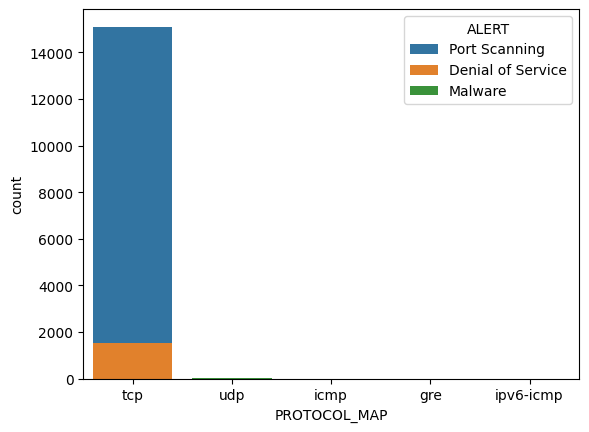

In [16]:
# Show protocol_map distribution for kind of ALERT
sns.countplot(x='PROTOCOL_MAP', hue='ALERT', data=train_df)

In [17]:
# Find unique hosts (IP addresses) in the train and test data
train_src_hosts = train_df['IPV4_SRC_ADDR'].unique()
train_dst_hosts = train_df['IPV4_DST_ADDR'].unique()
train_hosts = np.union1d(train_src_hosts, train_dst_hosts)

# For each host, count the number of flows
print('Number of unique hosts in the train data: ', len(train_hosts))

# Find unique hosts (IP addresses) in the train and test data
test_src_hosts = test_df['IPV4_SRC_ADDR'].unique()
test_dst_hosts = test_df['IPV4_DST_ADDR'].unique()
test_hosts = np.union1d(test_src_hosts, test_dst_hosts)

# Floor ratio of hosts in test data that are not in train data
ratio = math.floor((1.0-len(test_hosts)/len(train_hosts)) * 100)

# For each host, count the number of flows
print("Number of unique hosts in the test data: {} (~{}% smaller)".format(len(test_hosts), ratio))


Number of unique hosts in the train data:  16875
Number of unique hosts in the test data: 11085 (~34% smaller)


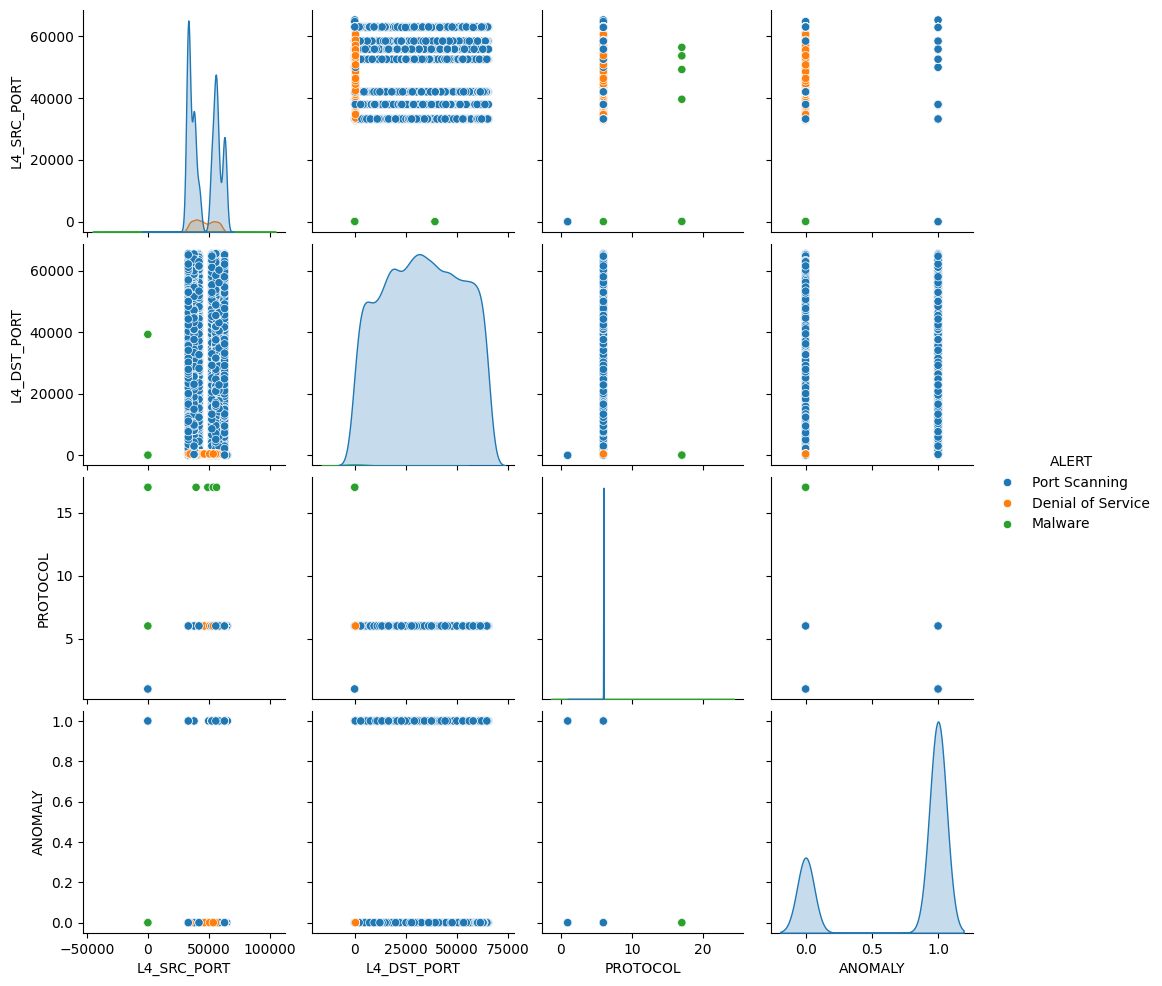

In [18]:
# select the columns to be used for training
train_df_columns = train_df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'ANOMALY', 'ALERT']]

# Distribution analysis using pairplot
sns.pairplot(train_df_columns, hue='ALERT')

In [22]:
# Intersect revoked_columns with the actual columns in the DataFrame
available_columns_to_drop = [col for col in revoked_columns if col in train_df.columns]

# Create dummy columns for the ALERT column
alert_dummies = pd.get_dummies(train_df['ALERT'], prefix='ALERT', drop_first=True)

# Copy + drop only available columns
train_df = train_df.copy().drop(available_columns_to_drop, axis=1)


In [23]:
missing_columns = [col for col in revoked_columns if col not in train_df.columns]
print(f"The following columns were not found in the DataFrame: {missing_columns}")


The following columns were not found in the DataFrame: ['FLOW_ID', 'ID', 'ANALYSIS_TIMESTAMP', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'PROTOCOL_MAP', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TOTAL_PKTS_EXP', 'TOTAL_BYTES_EXP']


<Axes: >

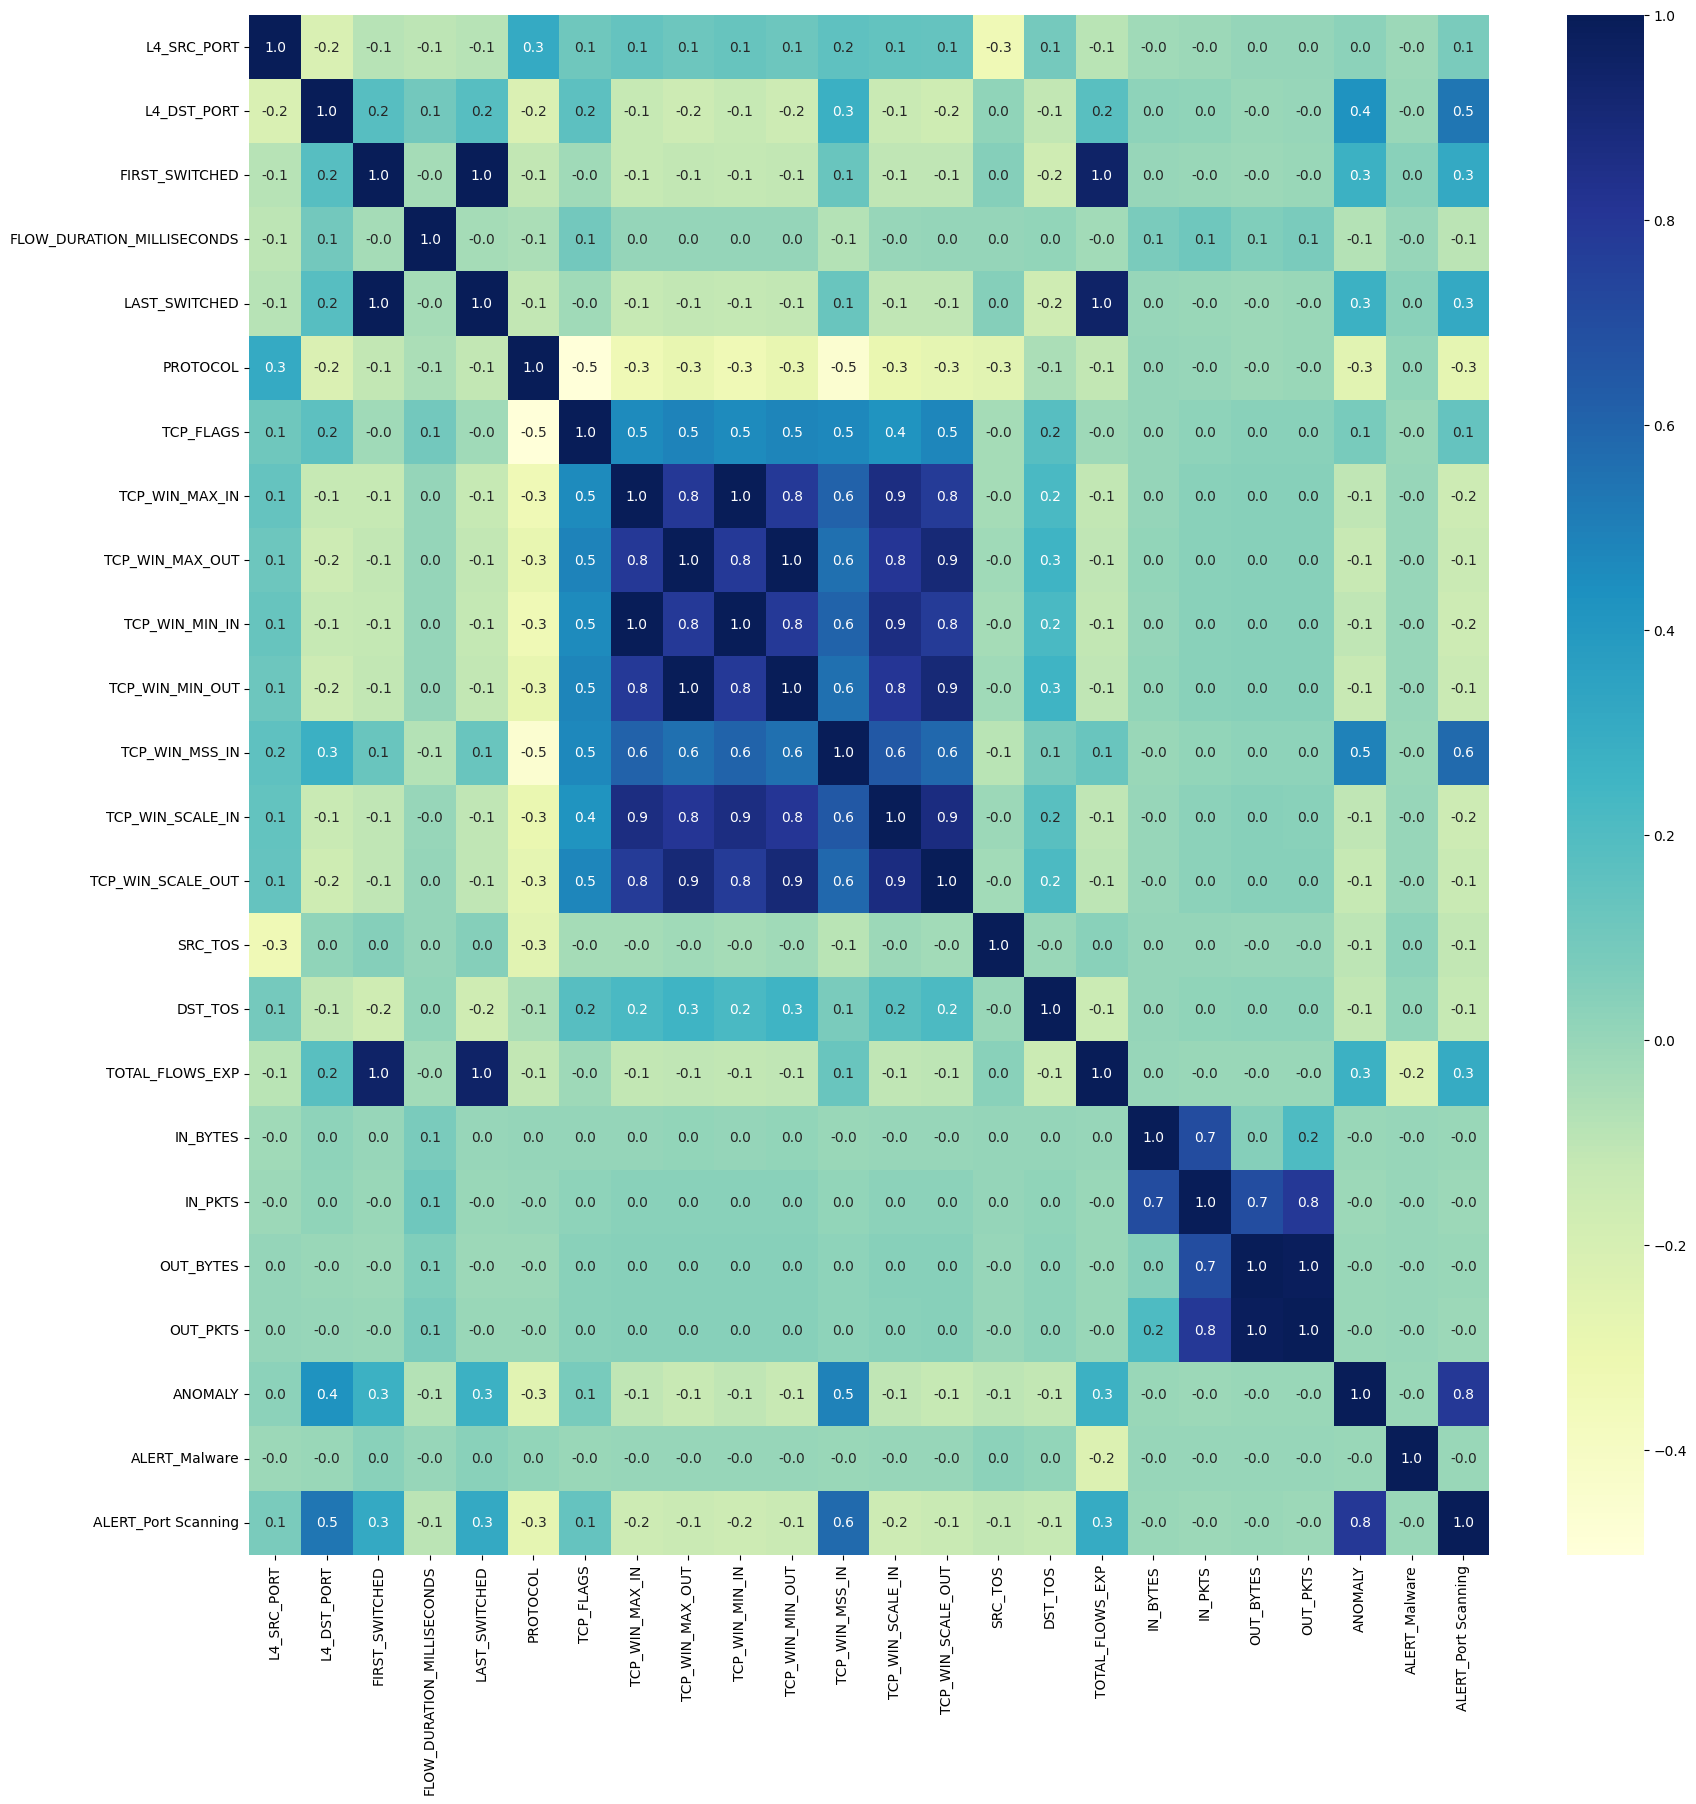

In [24]:
# Correlation heatmap using pandas
corr = pd.concat([train_df.drop('ALERT', axis=1), alert_dummies], axis=1).corr(
  numeric_only=False, # Only consider numeric columns
)

# Correlation heatmap using seaborn + make annotations fit the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")

In [25]:
def split_maintain_distribution(X, y):
  sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=9)
  indexes = sss.split(X, y)
  train_indices, test_indices = next(indexes)
  return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

In [27]:
# Check for NaN values in the feature matrix and target vector
print("Missing values in features (X):")
print(train_df.drop('ALERT', axis=1).isnull().sum())

print("\nMissing values in target (y):")
print(train_df['ALERT'].isnull().sum())

# Handle missing values
# Option 1: Drop rows with NaN in either features or target
train_df_cleaned = train_df.dropna(subset=train_df.columns)

# Option 2: Impute missing values (example: filling with mean for numerical columns)
# train_df_cleaned = train_df.fillna(train_df.mean())

# Perform the split after cleaning the data
X_train, X_val, y_train, y_val = split_maintain_distribution(
    train_df_cleaned.drop('ALERT', axis=1),
    train_df_cleaned['ALERT']
)


Missing values in features (X):
L4_SRC_PORT                   0
L4_DST_PORT                   0
FIRST_SWITCHED                0
FLOW_DURATION_MILLISECONDS    0
LAST_SWITCHED                 0
PROTOCOL                      0
TCP_FLAGS                     0
TCP_WIN_MAX_IN                0
TCP_WIN_MAX_OUT               0
TCP_WIN_MIN_IN                0
TCP_WIN_MIN_OUT               0
TCP_WIN_MSS_IN                0
TCP_WIN_SCALE_IN              0
TCP_WIN_SCALE_OUT             0
SRC_TOS                       0
DST_TOS                       0
TOTAL_FLOWS_EXP               0
IN_BYTES                      0
IN_PKTS                       0
OUT_BYTES                     0
OUT_PKTS                      0
ANOMALY                       0
dtype: int64

Missing values in target (y):
109891


In [28]:
print(train_df.isnull().sum())


L4_SRC_PORT                        0
L4_DST_PORT                        0
FIRST_SWITCHED                     0
FLOW_DURATION_MILLISECONDS         0
LAST_SWITCHED                      0
PROTOCOL                           0
TCP_FLAGS                          0
TCP_WIN_MAX_IN                     0
TCP_WIN_MAX_OUT                    0
TCP_WIN_MIN_IN                     0
TCP_WIN_MIN_OUT                    0
TCP_WIN_MSS_IN                     0
TCP_WIN_SCALE_IN                   0
TCP_WIN_SCALE_OUT                  0
SRC_TOS                            0
DST_TOS                            0
TOTAL_FLOWS_EXP                    0
IN_BYTES                           0
IN_PKTS                            0
OUT_BYTES                          0
OUT_PKTS                           0
ANOMALY                            0
ALERT                         109891
dtype: int64


In [29]:
train_df.dropna(inplace=True)


In [30]:
# Print distribution of the target variable in the train and validation sets
print('Train set distribution:')
print(y_train.value_counts(normalize=True))
print()
print('Validation set distribution:')
print(y_val.value_counts(normalize=True))

Train set distribution:
ALERT
Port Scanning        0.907889
Denial of Service    0.091134
Malware              0.000977
Name: proportion, dtype: float64

Validation set distribution:
ALERT
Port Scanning        0.907752
Denial of Service    0.091046
Malware              0.001202
Name: proportion, dtype: float64


In [31]:
print(train_df.isnull().sum().sum())  # Should output 0 if no NaNs remain


0


In [32]:
X_train, X_val, y_train, y_val = split_maintain_distribution(train_df.drop('ALERT', axis=1), train_df['ALERT'])


In [33]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def split_maintain_distribution(X, y):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=9)
    indexes = sss.split(X, y)
    train_indices, test_indices = next(indexes)
    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]



In [34]:
# Replace NaN values in numeric columns with the median of each column
numeric_cols = train_df.select_dtypes(include=['number']).columns
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())

# Replace NaN values in non-numeric columns (optional)
non_numeric_cols = train_df.select_dtypes(exclude=['number']).columns
train_df[non_numeric_cols] = train_df[non_numeric_cols].fillna('Unknown')  # Replace with 'Unknown' or another placeholder


In [35]:
# Split the data
X_train, X_val, y_train, y_val = split_maintain_distribution(train_df.drop('ALERT', axis=1), train_df['ALERT'])

In [36]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

In [37]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100) # 100 trees = default value

# Fit the model
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier()

In [38]:
# Print features importance
feature_importances = pd.DataFrame(
    rfc.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
print(feature_importances)

                            importance
TOTAL_FLOWS_EXP               0.197886
FIRST_SWITCHED                0.192398
IN_BYTES                      0.123667
L4_DST_PORT                   0.102417
LAST_SWITCHED                 0.092181
IN_PKTS                       0.091529
TCP_WIN_SCALE_IN              0.079173
TCP_WIN_MAX_IN                0.042588
FLOW_DURATION_MILLISECONDS    0.038113
TCP_WIN_MIN_IN                0.010299
OUT_BYTES                     0.009846
OUT_PKTS                      0.009008
TCP_FLAGS                     0.004181
ANOMALY                       0.003585
SRC_TOS                       0.001155
PROTOCOL                      0.000527
DST_TOS                       0.000428
TCP_WIN_MSS_IN                0.000323
L4_SRC_PORT                   0.000288
TCP_WIN_MIN_OUT               0.000202
TCP_WIN_MAX_OUT               0.000174
TCP_WIN_SCALE_OUT             0.000031


<Axes: xlabel='None', ylabel='importance'>

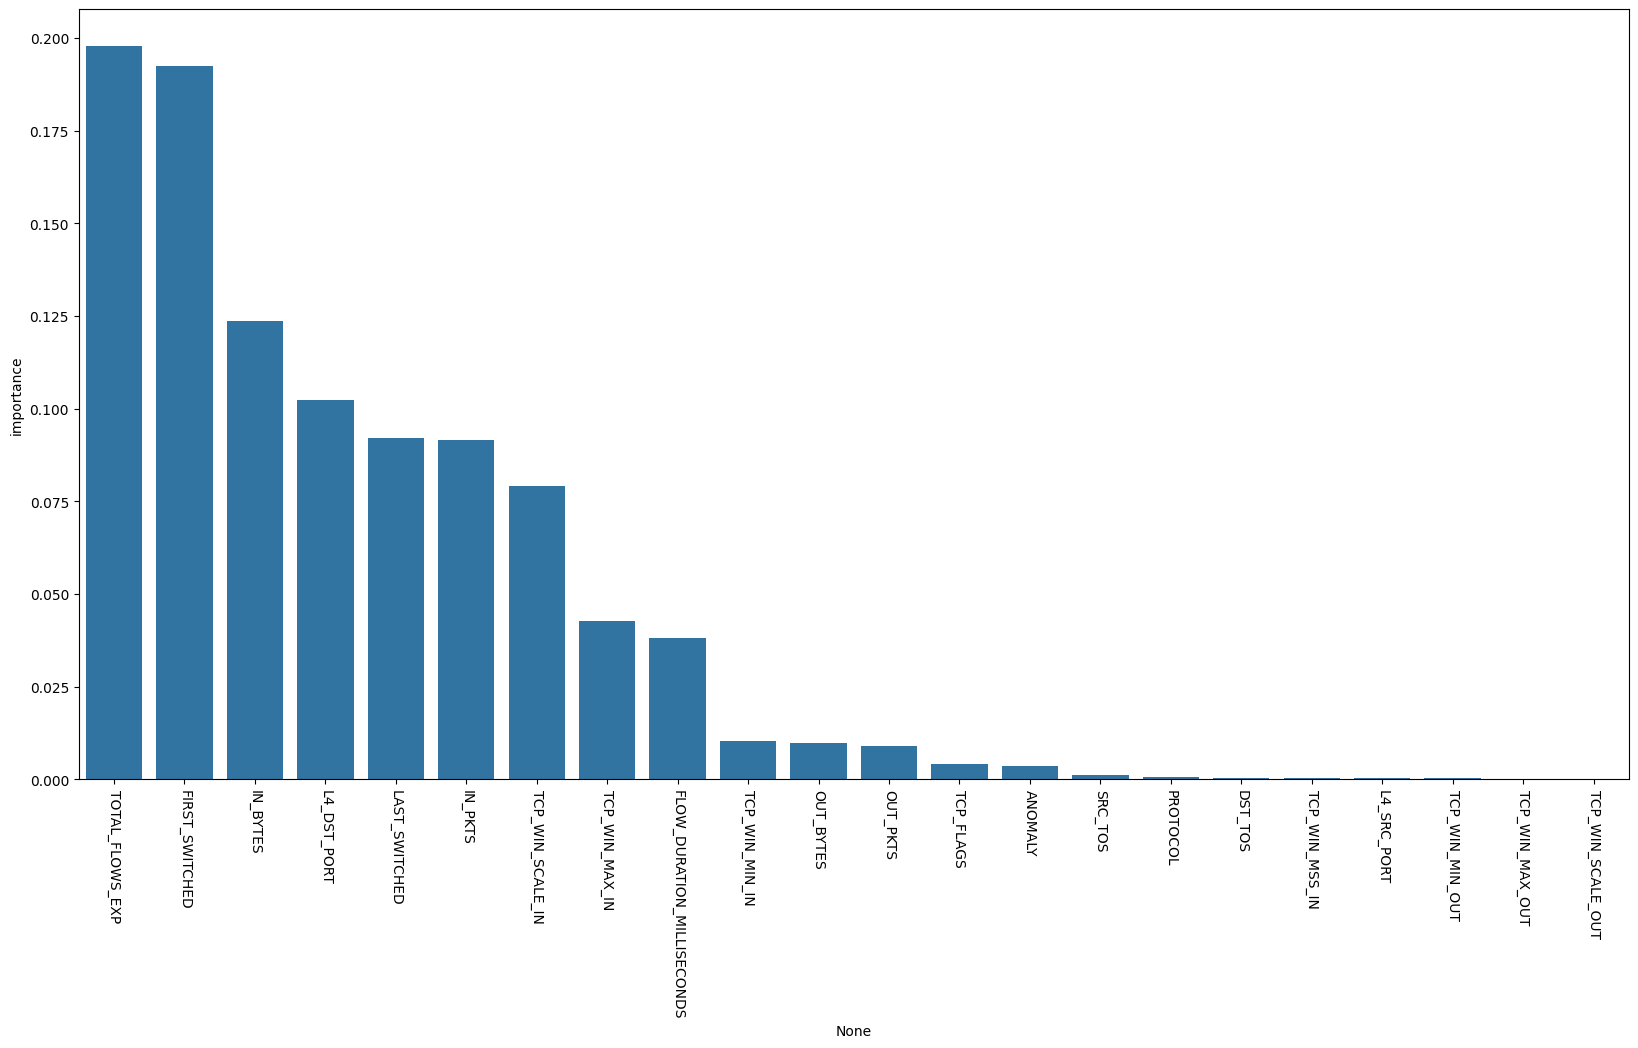

In [39]:
# Plot feature importance
plt.figure(figsize=(20, 10))
plt.xticks(rotation=-90)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])

In [40]:
MIN_IMPORTANCE_THRESHOLD = 0.02

In [41]:
# Select all columns with importance > 0.02
COLUMNS = feature_importances[feature_importances['importance'] > MIN_IMPORTANCE_THRESHOLD].index
COLUMNS

Index(['TOTAL_FLOWS_EXP', 'FIRST_SWITCHED', 'IN_BYTES', 'L4_DST_PORT',
       'LAST_SWITCHED', 'IN_PKTS', 'TCP_WIN_SCALE_IN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS'],
      dtype='object')

In [42]:
X_train, X_val, y_train, y_val = split_maintain_distribution(
  train_df[COLUMNS],
  train_df['ALERT']
)

In [43]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

In [44]:
# No target variable, so no need to split the fit and transform
x_test_scaled = StandardScaler().fit_transform(test_df[COLUMNS])
# Convert to pandas dataframe
df_feat_test = pd.DataFrame(x_test_scaled, columns=test_df[COLUMNS].columns)

## UMAP visualization

In [45]:
import umap
reducer = umap.UMAP(
  random_state=42,
  n_neighbors=50,
  min_dist=0.3,
)
mapper = reducer.fit(x_train_scaled)

c:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP projection of the train set')

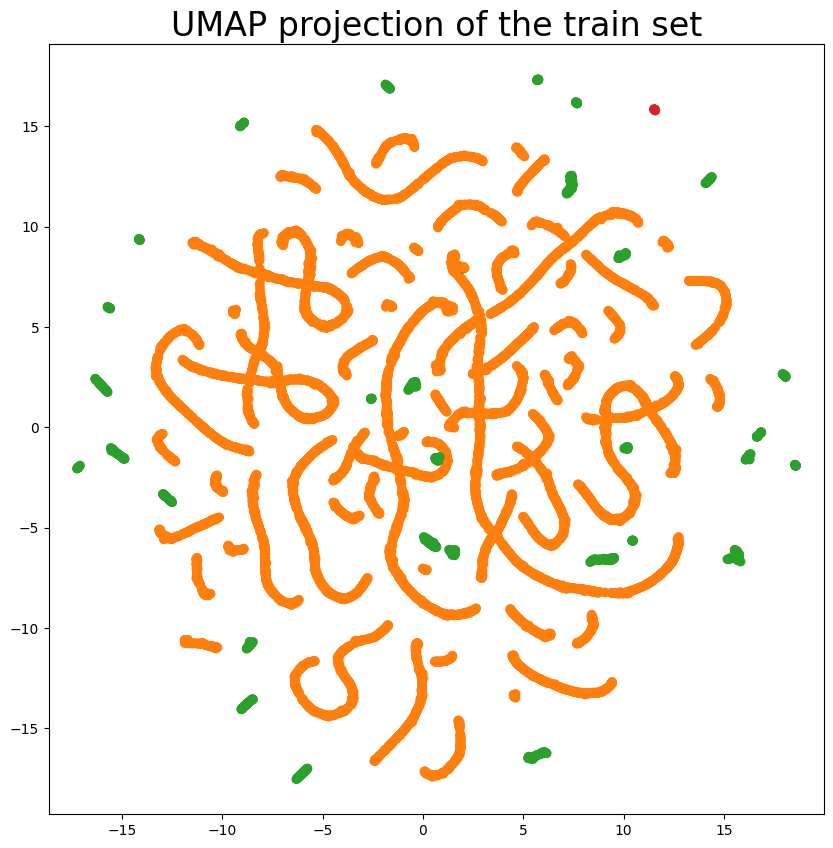

In [46]:
# Transform the train set
embedding = mapper.transform(x_train_scaled)

# Plot the train set
plt.figure(figsize=(10, 10))
plt.scatter(
  embedding[:, 0],
  embedding[:, 1],
  c=[sns.color_palette()[x] for x in y_train.map({'None': 0, 'Port Scanning': 1, 'Denial of Service': 2, 'Malware': 3})],
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the train set', fontsize=24)

In [47]:
import umap
import umap.plot

# Create UMAP reducer
reducer = umap.UMAP(
    random_state=42,
    n_neighbors=50,
    min_dist=0.3,
)

# Fit the UMAP reducer on the training data
mapper = reducer.fit(x_train_scaled)  # Ensure `x_train_scaled` is preprocessed and defined


c:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\pooja\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

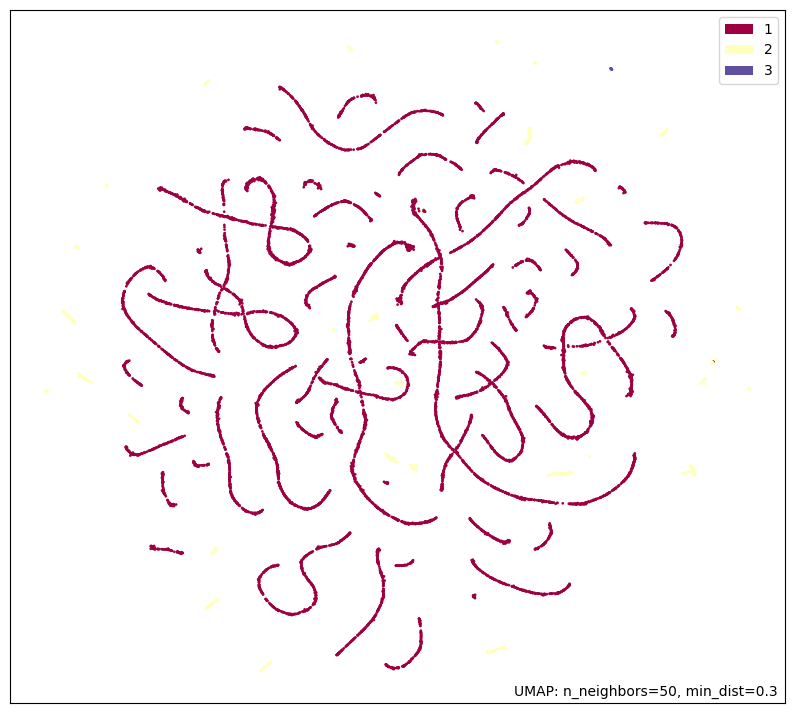

In [49]:
# Map labels to numeric values
labels = y_train.map({'None': 0, 'Port Scanning': 1, 'Denial of Service': 2, 'Malware': 3})

# Visualize the embedding
p = umap.plot.points(
    mapper,
    labels=labels,
    width=1000,
    height=900,
)
umap.plot.show(p)


## KNN Classifier training

In [50]:
# Find best K using GridSearchCV
MAX_DEGREE = 30

k_range = list(range(1, MAX_DEGREE+1))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best k: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Best k: {'n_neighbors': 1}
Best score: 0.999924874164225


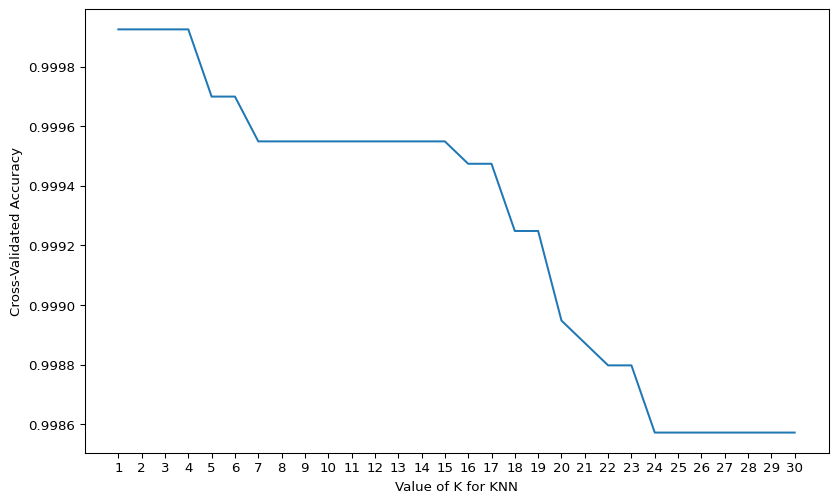

In [51]:
# Plot results
plt.figure(num=0, dpi=96, figsize=(10, 6))
plt.plot(k_range, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()

In [52]:
# Create a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3) # 3 = view note above
# Fit the classifier to the data
knn.fit(x_train_scaled, y_train)
# Make predictions on validation set
predictions = knn.predict(x_validation_scaled)

In [53]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      1.00      1.00         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      1.00      1.00      3328
     weighted avg       1.00      1.00      1.00      3328



In [54]:
print(sorted(y_val.unique()))  # Classes in `y_val`
print(sorted(np.unique(predictions)))  # Classes in `predictions`


['Denial of Service', 'Malware', 'Port Scanning']
['Denial of Service', 'Malware', 'Port Scanning']


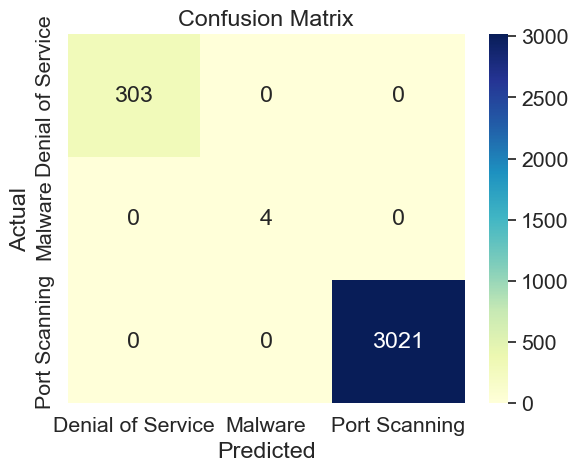

In [56]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cmat = confusion_matrix(y_val, predictions)

# Get the unique classes (Union of both y_val and predictions to handle edge cases)
unique_classes = sorted(set(y_val) | set(predictions))

# Rename the columns and index dynamically
cmat = pd.DataFrame(cmat, index=unique_classes, columns=unique_classes)

# Visualize the confusion matrix
sns.set(font_scale=1.4)  # For label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\983840576.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        57293
Denial of Service     5022
Malware                  5
Name: count, dtype: int64

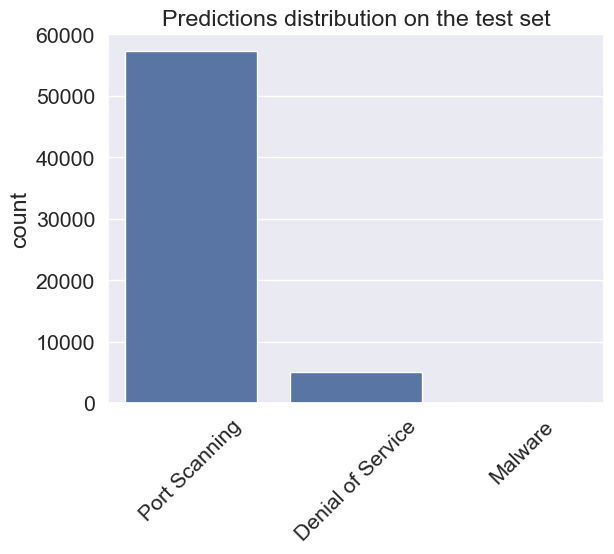

In [57]:
# Prediction on the test set
predictions = knn.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

In [58]:
# Create grid search parameters
param_grid = {
  'C': [0.1, 1, 10, 100, 1000],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

# Create grid search
svc_grid = GridSearchCV(
  SVC(kernel="rbf"),
  param_grid,
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1, # Use all cores
)

# Fit grid search
svc_grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best params: {svc_grid.best_params_}")
print(f"Best score: {svc_grid.best_score_}")

Best params: {'C': 10, 'gamma': 0.01}
Best score: 1.0


In [59]:
# Create SVM with best parameters
svc = SVC(
  kernel='rbf',
  C=svc_grid.best_params_['C'],
  gamma=svc_grid.best_params_['gamma'],
)
svc.fit(x_train_scaled, y_train)

SVC(C=10, gamma=0.01)

In [60]:
# Make predictions on validation set
predictions = svc.predict(x_validation_scaled)

In [61]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      0.75      0.86         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      0.92      0.95      3328
     weighted avg       1.00      1.00      1.00      3328



In [63]:
print(f"Shape of confusion matrix: {cmat.shape}")
print(f"Unique classes: {unique_classes}")


Shape of confusion matrix: (3, 3)
Unique classes: ['Denial of Service', 'Malware', 'Port Scanning']


y_val length: 3328
predictions length: 3328


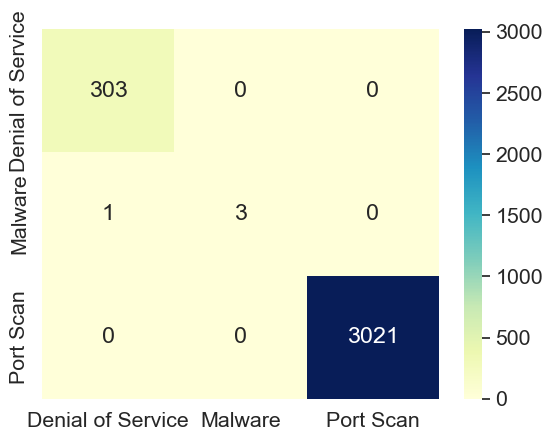

In [66]:
# Verify data lengths
print(f"y_val length: {len(y_val)}")
print(f"predictions length: {len(predictions)}")

# Align predictions with y_val if needed
predictions = predictions[:len(y_val)]

# Compute confusion matrix
cmat = confusion_matrix(y_val, predictions)

# Convert to DataFrame for better labeling
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'Port Scan'], columns=['Denial of Service', 'Malware', 'Port Scan'])

# Visualize the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\808094574.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        61961
Denial of Service      354
Malware                  5
Name: count, dtype: int64

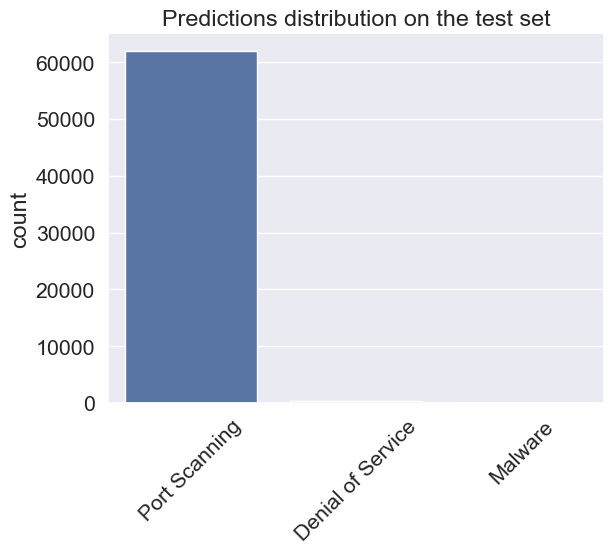

In [67]:
# Prediction on the test set
predictions = svc.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

####  PCA + SVC model training

In [68]:
# Create the two parameters
pca = PCA(whiten=True, random_state=42) # PCA (Principal Component Analysis)
svc = SVC(kernel='rbf', class_weight='balanced') # SVC (Support Vector Classification)

# Create pipeline
model = make_pipeline(pca, svc)

In [69]:
print(x_train_scaled.shape)

(13310, 9)


In [70]:
n_features = x_train_scaled.shape[1]
n_components = np.arange(1, n_features + 1)  # Minimum 1 component, up to all features

In [71]:
print("n_components:", n_components)


n_components: [1 2 3 4 5 6 7 8 9]


In [72]:
print(f"Number of features: {n_features}")


Number of features: 9


In [73]:
n_components = np.arange(2, min(n_features, 20), 3)  # Start from 2 and limit the max to `n_features`


In [74]:
n_features = x_train_scaled.shape[1]
n_components = np.arange(2, min(n_features, 20), 3)

param_grid = {
    'pca__n_components': n_components,
    'svc__C': [50, 100, 500, 1000, 5000, 10000],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Grid search
pipeline_grid = GridSearchCV(
    model,
    param_grid,
    cv=2,  # Only 2 folds because of the dataset size
    n_jobs=-1  # Use all cores
)
pipeline_grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best params: {pipeline_grid.best_params_}")
print(f"Best score: {pipeline_grid.best_score_}")


Best params: {'pca__n_components': 5, 'svc__C': 50, 'svc__gamma': 0.001}
Best score: 1.0


In [75]:
print(f"n_components range: {n_components}")

n_components range: [2 5 8]


In [76]:
# Now, create the desired pipeline
pca = PCA(
  n_components=pipeline_grid.best_params_['pca__n_components'],
  whiten=True,
  random_state=42
)
svc = SVC(kernel='rbf',
  class_weight='balanced',
  # Use the best parameters found by the grid search
  C=pipeline_grid.best_params_['svc__C'],
  gamma=pipeline_grid.best_params_['svc__gamma']
)
model = make_pipeline(pca, svc)
model.fit(x_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=5, random_state=42, whiten=True)),
                ('svc', SVC(C=50, class_weight='balanced', gamma=0.001))])

In [77]:
# Make predictions on validation set
predictions = model.predict(x_validation_scaled)

#####  Model evaluation

In [78]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      1.00      1.00         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      1.00      1.00      3328
     weighted avg       1.00      1.00      1.00      3328



In [79]:
print("Classes in y_val:", sorted(y_val.unique()))
print("Classes in predictions:", sorted(np.unique(predictions)))


Classes in y_val: ['Denial of Service', 'Malware', 'Port Scanning']
Classes in predictions: ['Denial of Service', 'Malware', 'Port Scanning']


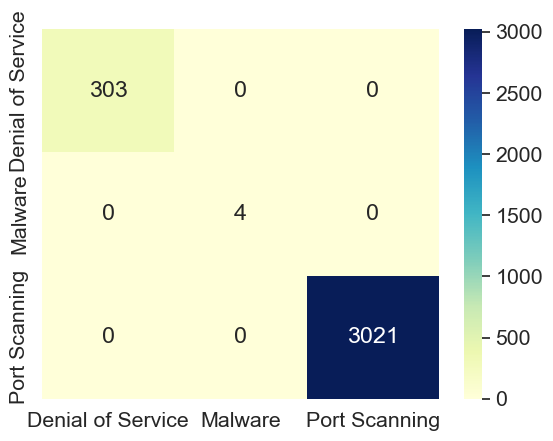

In [80]:
# Get the unique classes in the data
unique_classes = sorted(set(y_val) | set(predictions))

# Create the confusion matrix
cmat = confusion_matrix(y_val, predictions, labels=unique_classes)

# Convert to a DataFrame
cmat_df = pd.DataFrame(cmat, index=unique_classes, columns=unique_classes)

# Visualize the confusion matrix
sns.set(font_scale=1.4)  # For label size
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.show()


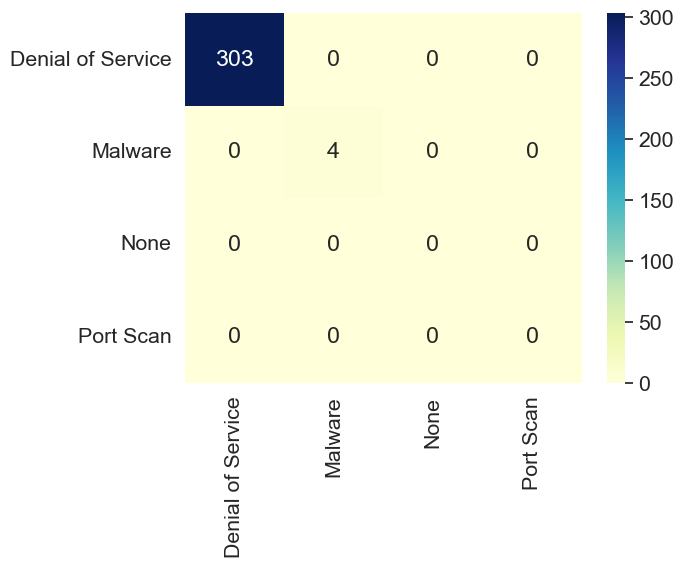

In [81]:
# Define all possible classes
all_classes = ['Denial of Service', 'Malware', 'None', 'Port Scan']

# Create confusion matrix and ensure missing rows/columns are filled with 0
cmat = confusion_matrix(y_val, predictions, labels=all_classes)
cmat_df = pd.DataFrame(cmat, index=all_classes, columns=all_classes)

# Visualize the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.show()


C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\674104990.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        56467
Denial of Service     5848
Malware                  5
Name: count, dtype: int64

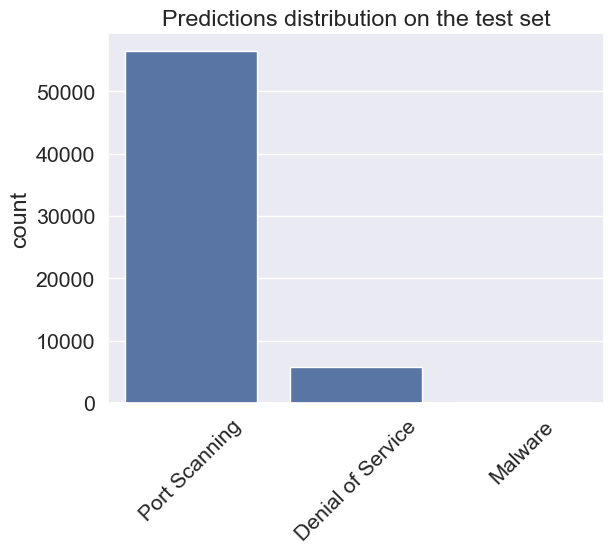

In [82]:
# Prediction on the test set
predictions = model.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

In [83]:
svc = SVC(kernel='rbf',
  class_weight='balanced',
  C=svc_grid.best_params_['C'],
  gamma=svc_grid.best_params_['gamma']
)

clf = BaggingClassifier(
  svc,
  n_estimators=30,
  n_jobs=-1, # Use all cores
  random_state=42
)
clf.fit(x_train_scaled, y_train)

BaggingClassifier(estimator=SVC(C=10, class_weight='balanced', gamma=0.01),
                  n_estimators=30, n_jobs=-1, random_state=42)

In [84]:
predictions = clf.predict(x_validation_scaled)

#### 7.3.3. Model evaluation

In [85]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      0.75      0.86         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      0.92      0.95      3328
     weighted avg       1.00      1.00      1.00      3328



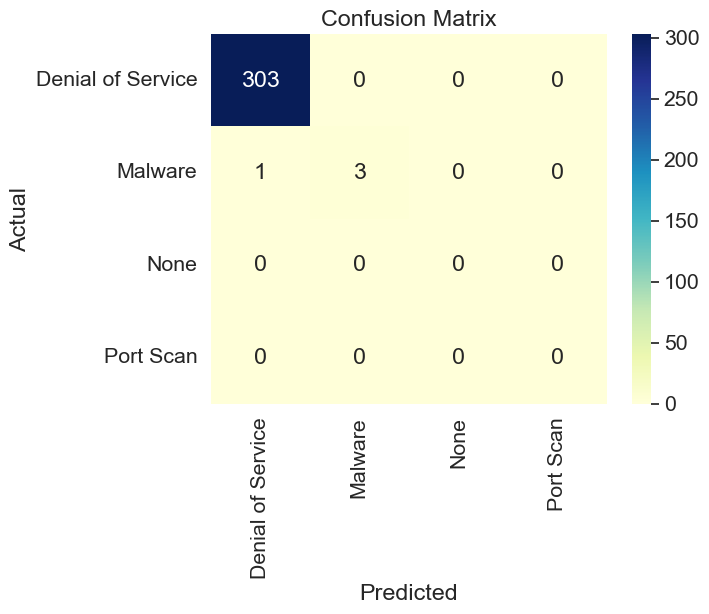

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define all possible classes
all_classes = ['Denial of Service', 'Malware', 'None', 'Port Scan']

# Create the confusion matrix with all classes
cmat = confusion_matrix(y_val, predictions, labels=all_classes)

# Convert to a DataFrame
cmat_df = pd.DataFrame(cmat, index=all_classes, columns=all_classes)

# Visualize the confusion matrix
sns.set(font_scale=1.4)  # Adjust font scale for readability
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


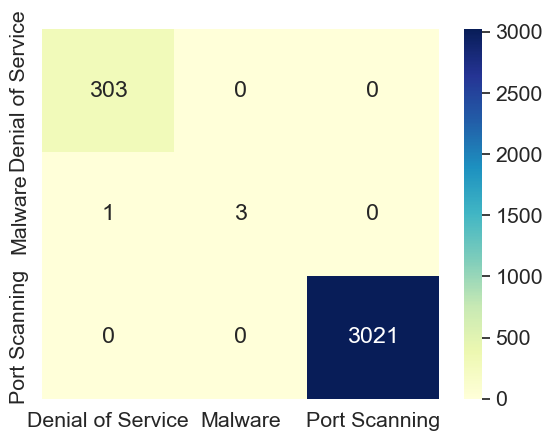

In [87]:
# Get unique classes in y_val and predictions
unique_classes = sorted(set(y_val).union(set(predictions)))

# Create confusion matrix with these unique classes
cmat = confusion_matrix(y_val, predictions, labels=unique_classes)

# Convert to DataFrame
cmat_df = pd.DataFrame(cmat, index=unique_classes, columns=unique_classes)

# Visualize
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu')
plt.show()


####  Bagging Classifier predictions on test set

C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\3725699281.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        61950
Denial of Service      365
Malware                  5
Name: count, dtype: int64

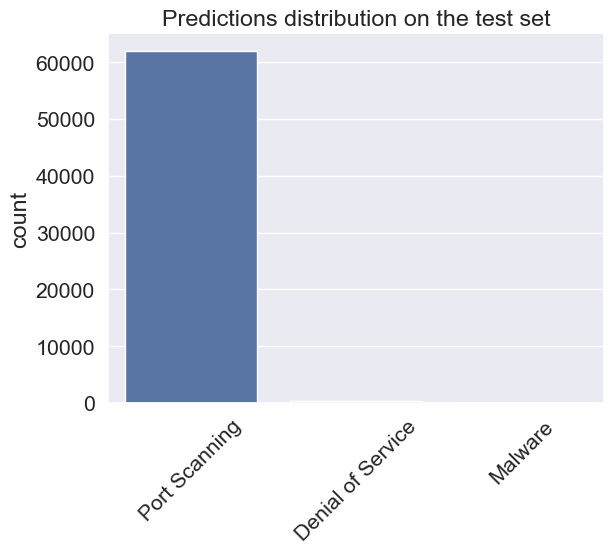

In [88]:
# Prediction on the test set
predictions = clf.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

## Random Forest Classifier training



In [89]:
# Create random forest classifier
rfc = RandomForestClassifier()

# Create a dictionary of all values we want to test for n_estimators
parameters = {'n_estimators': [1, 2, 4, 10, 15, 20, 30, 40, 50, 100, 200, 500, 1000]}

# Used to find the best n_estimators value to use to train the model
rfc_grid = GridSearchCV(
  rfc,
  parameters,
  scoring='accuracy',
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1 # Use all cores
)

# Fit model to data
rfc_grid.fit(x_train_scaled, y_train)

# Extract best params
print(f"Best params: {rfc_grid.best_params_}")
print(f"Best score: {rfc_grid.best_score_}")

Best params: {'n_estimators': 2}
Best score: 1.0


In [90]:
rfc = RandomForestClassifier(n_estimators=rfc_grid.best_params_['n_estimators'])
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier(n_estimators=2)

In [91]:
# Make predictions on validation set
predictions = rfc.predict(x_validation_scaled)

#### Model evaluation

In [92]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      1.00      1.00         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      1.00      1.00      3328
     weighted avg       1.00      1.00      1.00      3328



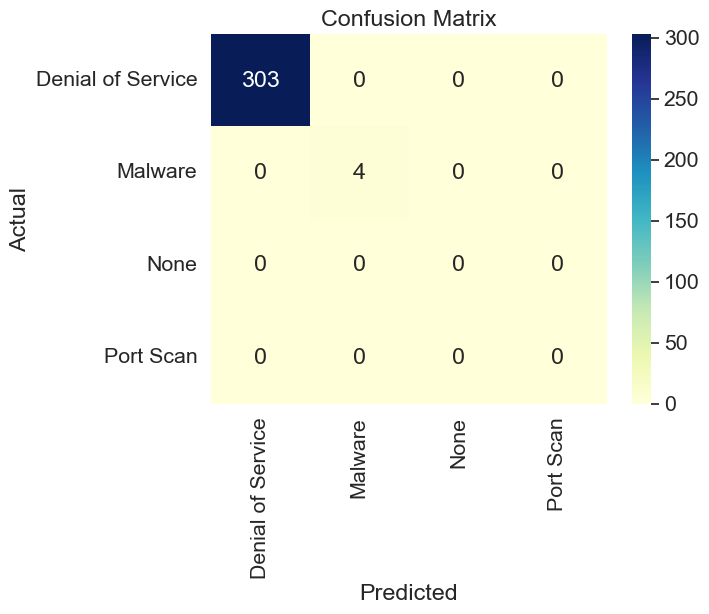

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define all classes (including those not appearing in y_val or predictions)
all_classes = ['Denial of Service', 'Malware', 'None', 'Port Scan']

# Generate confusion matrix including all classes
cmat = confusion_matrix(y_val, predictions, labels=all_classes)

# Convert the confusion matrix to a DataFrame
cmat_df = pd.DataFrame(cmat, index=all_classes, columns=all_classes)

# Visualize the confusion matrix with seaborn
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


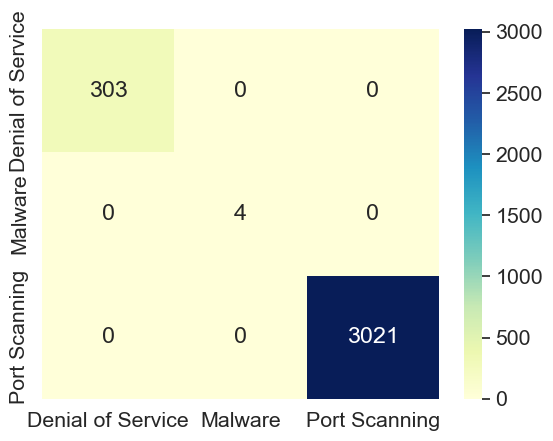

In [95]:
# Get unique classes in y_val and predictions
unique_classes = sorted(set(y_val).union(set(predictions)))

# Generate confusion matrix with dynamically detected classes
cmat = confusion_matrix(y_val, predictions, labels=unique_classes)

# Convert to DataFrame
cmat_df = pd.DataFrame(cmat, index=unique_classes, columns=unique_classes)

# Visualize
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.show()


#### Random Forest model predictions on test set

C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\2659482637.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning    62315
Malware              5
Name: count, dtype: int64

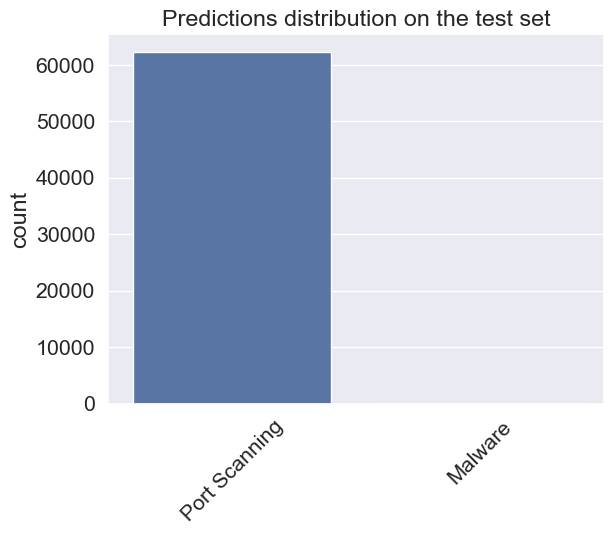

In [96]:
# Prediction on the test set
predictions = rfc.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

###  Extra Trees Classifier training

This kind of classifier is an ensemble of decision trees. It is similar to a Random Forest classifier, but the trees are trained using the whole dataset instead of a bootstrap sample.

In [98]:
# Create random forest classifier
etc = ExtraTreesClassifier()

# Create a dictionary of all values we want to test for n_estimators
parameters = {'n_estimators': [1, 2, 4, 10, 15, 20, 30, 40, 50, 100, 200, 500]}

# Used to find the best n_estimators value to use to train the model
etc_grid = GridSearchCV(
  etc,
  parameters,
  scoring='accuracy',
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1 # Use all cores
)

# Fit model to data
etc_grid.fit(x_train_scaled, y_train)

# Extract best params
print(f"Best params: {etc_grid.best_params_}")
print(f"Best score: {etc_grid.best_score_}")

Best params: {'n_estimators': 1}
Best score: 0.9999248685199098


In [99]:
etc = ExtraTreesClassifier(n_estimators=etc_grid.best_params_['n_estimators'])
etc.fit(x_train_scaled, y_train)

ExtraTreesClassifier(n_estimators=1)

In [100]:
# Make predictions on validation set
predictions = etc.predict(x_validation_scaled)

#### Model evaluation

In [101]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      1.00      1.00         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      1.00      1.00      3328
     weighted avg       1.00      1.00      1.00      3328



In [102]:
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of predictions: {predictions.shape}")

Shape of y_val: (3328,)
Shape of predictions: (3328,)


In [103]:
predictions = predictions[:len(y_val)]

Shape of y_val: (3328,)
Shape of predictions: (3328,)


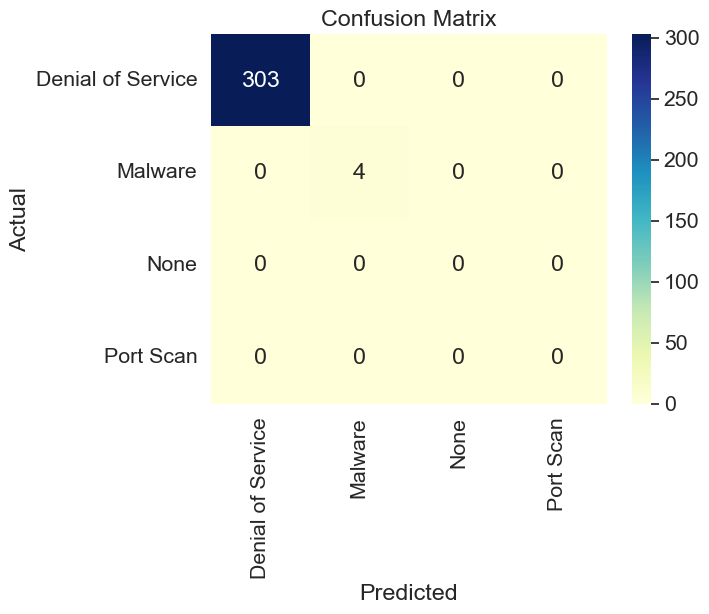

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Check shapes of y_val and predictions
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of predictions: {predictions.shape}")

# Align predictions with y_val if necessary
if len(predictions) > len(y_val):
    predictions = predictions[:len(y_val)]

# Define all possible classes
all_classes = ['Denial of Service', 'Malware', 'None', 'Port Scan']

# Generate the confusion matrix
cmat = confusion_matrix(y_val, predictions, labels=all_classes)

# Convert to DataFrame
cmat_df = pd.DataFrame(cmat, index=all_classes, columns=all_classes)

# Visualize using seaborn
sns.set(font_scale=1.4)
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


####  Extra Trees model predictions on test set

C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\531166074.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        51571
Denial of Service    10744
Malware                  5
Name: count, dtype: int64

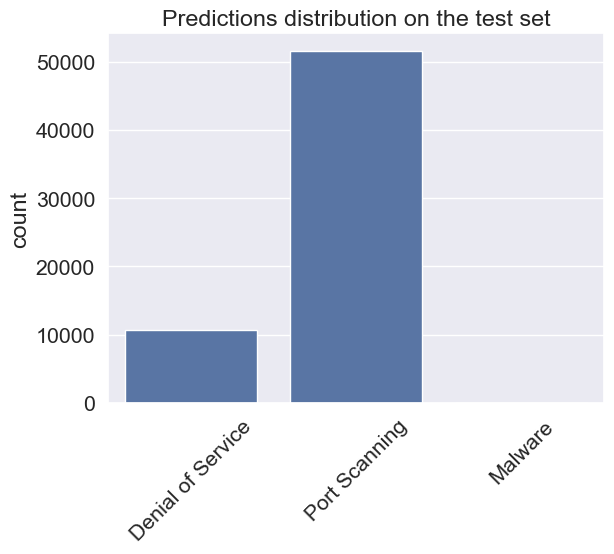

In [105]:
# Prediction on the test set
predictions = etc.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

###  Neural Network classifier training

In [106]:
# Create MLPClasifier
mlp = MLPClassifier(
  max_iter=1000,
  random_state=42
)

# Grid search for MLPClassifier
parameters = {
  'hidden_layer_sizes': [(50,), (100,), (50, 50)],
  'activation': ['relu', 'tanh'],
  'alpha': [0.0001, 0.001],
  'solver': ['adam', 'lbfgs'],
  'learning_rate': ['constant', 'invscaling'],
}

mlp_grid = GridSearchCV(
  mlp,
  parameters,
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1, # Use all cores
)

mlp_grid.fit(x_train_scaled, y_train)

GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'learning_rate': ['constant', 'invscaling'],
                         'solver': ['adam', 'lbfgs']})

In [109]:
# Extract best params
print(f"Best params: {mlp_grid.best_params_}")
print(f"Best score: {mlp_grid.best_score_}")

Best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.9999248685199098


In [110]:
# Create MLPClassifier with best parameters
mlp = MLPClassifier(
  hidden_layer_sizes=mlp_grid.best_params_['hidden_layer_sizes'],
  activation=mlp_grid.best_params_['activation'],
  alpha=mlp_grid.best_params_['alpha'],
  solver=mlp_grid.best_params_['solver'],
  learning_rate=mlp_grid.best_params_['learning_rate'],
  max_iter=1000,
  random_state=42
)
mlp.fit(x_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)

In [111]:
# Make predictions on validation set
predictions = mlp.predict(x_validation_scaled)

####  Model evaluation

In [112]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      1.00      1.00         4
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00      3328
        macro avg       1.00      1.00      1.00      3328
     weighted avg       1.00      1.00      1.00      3328



In [113]:
print(f"Unique classes in y_val: {np.unique(y_val)}")
print(f"Unique classes in predictions: {np.unique(predictions)}")


Unique classes in y_val: ['Denial of Service' 'Malware' 'Port Scanning']
Unique classes in predictions: ['Denial of Service' 'Malware' 'Port Scanning']


Unique classes in y_val: ['Denial of Service' 'Malware' 'Port Scanning']
Unique classes in predictions: ['Denial of Service' 'Malware' 'Port Scanning']


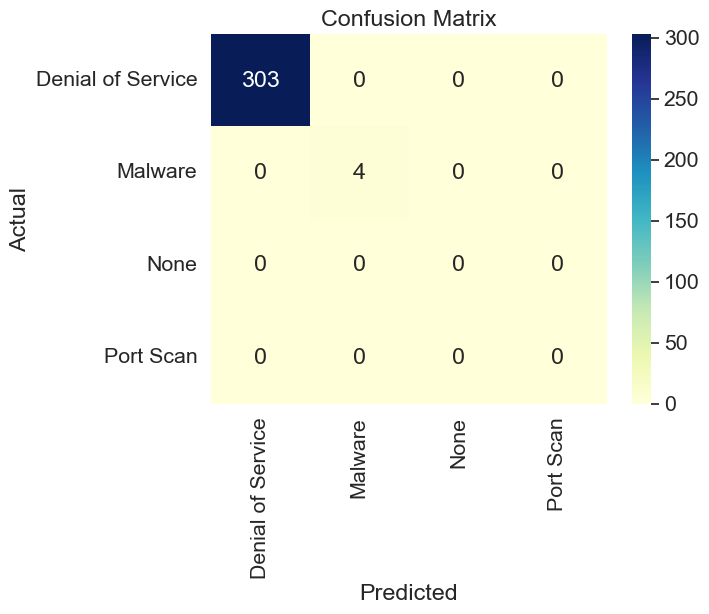

In [114]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Check the unique values in y_val and predictions
print(f"Unique classes in y_val: {np.unique(y_val)}")
print(f"Unique classes in predictions: {np.unique(predictions)}")

# Define the classes
all_classes = ['Denial of Service', 'Malware', 'None', 'Port Scan']

# Generate the confusion matrix
cmat = confusion_matrix(y_val, predictions, labels=all_classes)

# Convert to a DataFrame with correct labels
cmat_df = pd.DataFrame(cmat, index=all_classes, columns=all_classes)

# Visualize using seaborn
sns.set(font_scale=1.4)
sns.heatmap(cmat_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


####  MPL classifier model predictions on test set

C:\Users\pooja\AppData\Local\Temp\ipykernel_26812\2057250653.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


Port Scanning        53016
Denial of Service     9299
Malware                  5
Name: count, dtype: int64

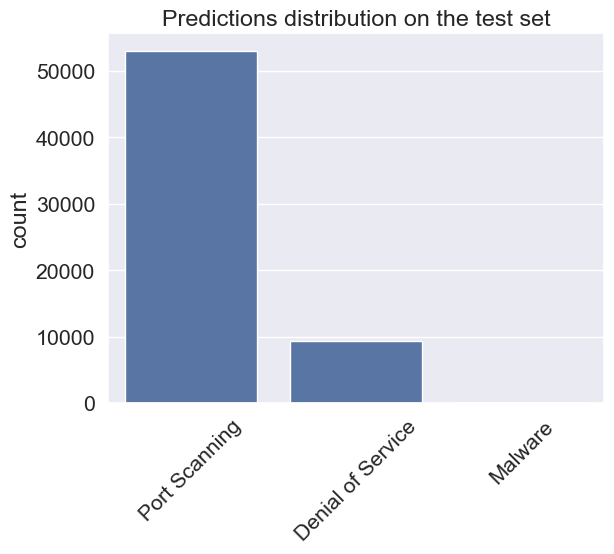

In [115]:
# Prediction on the test set
predictions = mlp.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class